# 1	Подбор алгоритма обучения


### Распланируем наш алгоритм обучения для распознования автомобильных номеров

Для начала чтобы определить где находятся номера на нашей картинке мы используем модель yolov5. Модель yolo позволит нам определять сразу несколько номеров, если такие имеются, на картинке с первого прохода модели, что упрощает процесс сканирования и нахождения номеров автомобилей. Мы берём модель yolo также для экономии времени, т.к. создание полноценного решения для локализации требуется много сил, строчек кода и попыток. А в случае с дообучением модели мы берём уже обученные веса со структурой модели и дообучаем их на свои данные, что будет быстрее, эффективней и точнее.

После того как мы обучим модель yolo мы должны обрезать наши автомобильные номера у которых есть предразмеченное текстовое обозначение спрятанное в названии. Это послужит данными для нашей следующей модели, которая будет определять текст на картинке. В угоду сэкономленного времени создадим свою модель для определения текста на картинке. 

[LPR OCR Example](https://www.kaggle.com/code/nickyazdani/lpr-ocr-example)

# 2	Импорт данных для обучения нейронной сети


In [1]:
import os
import shutil
import json

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np

import random
from glob import glob


from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision import models
import cv2

from collections import Counter

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")

True
cuda
Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device: NVIDIA GeForce RTX 4060
How many devices 1


Скопируем изображения

In [2]:
os.makedirs('./data/parced/annotations', exist_ok=True)
os.makedirs('./data/parced/images', exist_ok=True)

In [3]:
shutil.copytree('./data/yolo-to-coco_data/images', './data/parced/images', dirs_exist_ok=True)

'./data/parced/images'

Импортируем наши данные о разметке из файла ./yolo-to-coco_data/all.json

In [4]:
def convert_bbox_coco2yolo(img_width, img_height, bbox):
    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]


with open('./data/yolo-to-coco_data/all.json') as f:
    data = json.load(f)
    img_data = data['images']
    annot_data = data['annotations']  # images, categories, annotations
annot_df = pd.DataFrame(annot_data)

for img in img_data:
    annot = annot_df.loc[annot_df['image_id'] == img['id'], ['category_id', 'bbox', 'image_id']]
    if not annot.empty:
        with open(f'./data/parced/annotations/{img["file_name"][:-4] + ".txt"}', 'w') as f:
            for _, row in annot.iterrows():
                text = str(row['category_id'] - 1) + ' ' + ' '.join(
                    map(str, convert_bbox_coco2yolo(img['width'], img['height'], row['bbox'])
                        )) + '\n'
                f.write(text)
    else:
        with open(f'./data/parced/annotations/{img["file_name"][:-4] + ".txt"}', 'w') as f:
            print('Created')

Мы официально распарсили свой датасет в директорию ./data/parced

In [6]:
path = './data/parced'
txts = os.listdir(os.path.join(path, 'annotations'))
imgs = os.listdir(os.path.join(path, 'images'))
txts_with_classes = {}
for txt in txts:
    with open(os.path.join(r'./data/parced/annotations', txt), 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line != '\n':
                try:
                    txts_with_classes[txt[:-4] + '.jpg'] += [int(line[:1])]
                except KeyError:
                    txts_with_classes[txt[:-4] + '.jpg'] = [int(line[:1])]
classes_list = [0]

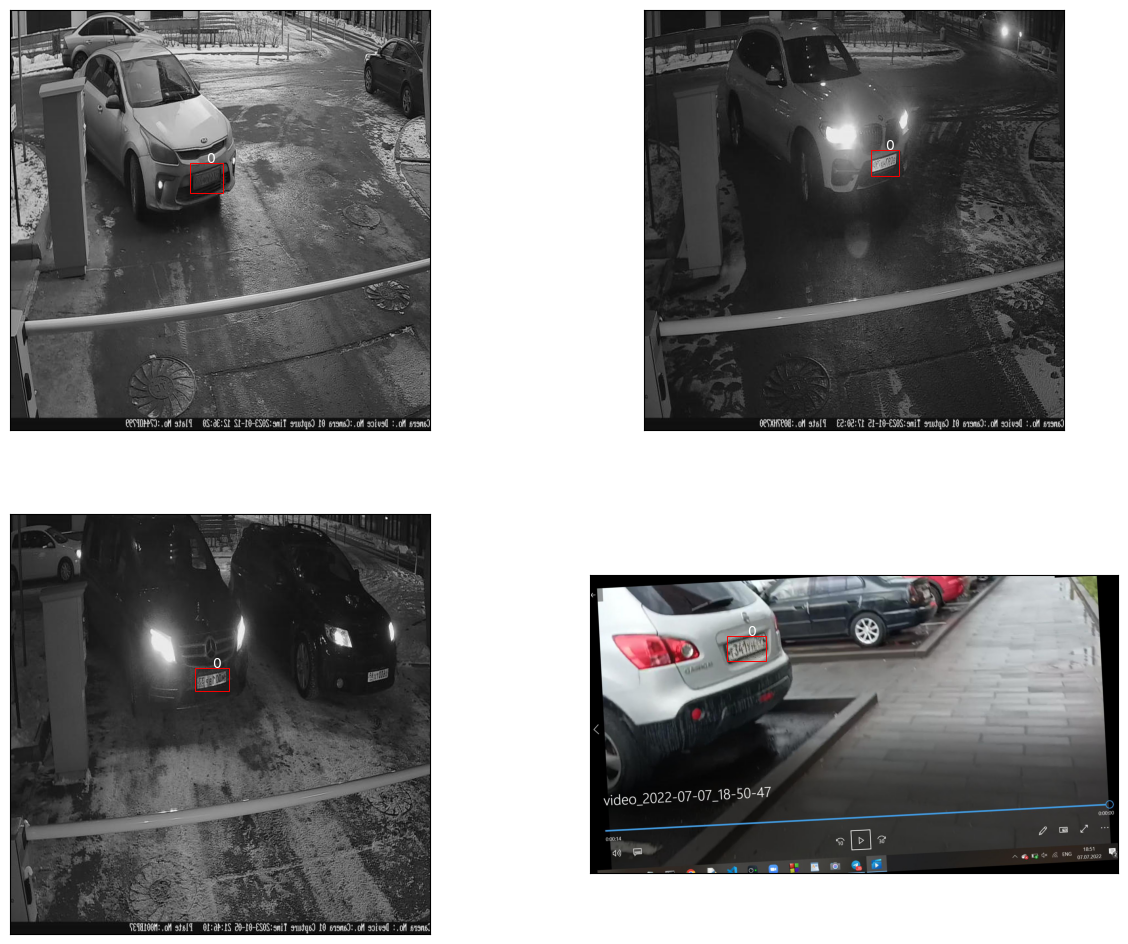

In [11]:
for damage_class in range(1):
    scale = 2
    class_indx = [i for i, x in enumerate(map(lambda x: damage_class in x, txts_with_classes.values())) if
                  x == True]

    fig, axes = plt.subplots(nrows=scale, ncols=scale, figsize=(15, 12),  #Размер вывода
                             subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes):
        for count in range(scale):
            jpg_name = list(txts_with_classes)[class_indx[random.randrange(0, len(class_indx))]]  # image_indx
            img = plt.imread(os.path.join('./data/parced/images', jpg_name))
            ax[count].imshow(img)
            h, w = np.shape(img)[0], np.shape(img)[1]
            txt_name = jpg_name[:-4] + '.txt'
            with open(os.path.join('./data/parced/annotations', txt_name)) as file:
                lines = file.readlines()
                for line in lines:
                    if line[0] == f'{damage_class}':
                        _, x_, y_, w_, h_ = list(map(float, line.split()))
                        x1 = w * x_ - 0.5 * w * w_
                        y1 = h * y_ - 0.5 * h * h_
                        x2 = w * x_ + 0.5 * w * w_
                        y2 = h * y_ + 0.5 * h * h_
                        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=0.7, edgecolor='r',
                                                 facecolor='none')
                        ax[count].text((x2 - x1) / 2 + x1, y1, classes_list[damage_class], color='white')
                        ax[count].add_patch(rect)

Теперь чтобы обучить нашу yolo модель нам нужно подготовить несколько файлов и разделить данные на обучающую и валидационную выборки 

In [14]:
for dir1 in ['train', 'val']:
    for dir2 in ['images', 'labels']:
        os.makedirs(f'./data//splitted/{dir1}/{dir2}', exist_ok=True)

path = './data/parced'
dest_path = './data/splitted'
files = os.listdir(path + '/images')
random.shuffle(files)
training = files[:int(len(files) * 0.8)]
validation = files[int(len(files) * 0.8):int(len(files) * 1) + 1]
for train in training:
    shutil.copy(path + '/images/' + train, dest_path + '/train/images/')
    shutil.copy(path + '/annotations/' + train[:-4] + '.txt',
                dest_path + '/train/labels/')
for val in validation:
    shutil.copy(path + '/images/' + val, dest_path + '/val/images/')
    shutil.copy(path + '/annotations/' + val[:-4] + '.txt',
                dest_path + '/val/labels/')

# GitHub Yolov5

Скопируем github репозиторий yolov5 и установим все необходимые библиотеки для обучения этой модели и последующего заполнения наших данных

In [15]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\car_license-plate\B\yolov5


Cloning into 'yolov5'...


D:\Github proj\MachineLearning\ML\Neuro-webs_competition\car_license-plate\B


In [16]:
import yaml

data = {
    'train': r'..\data\splitted\train',
    'val': r'..\data\splitted\val',
    'nc': '1',
    'names': {0: 'licence_plate'}
}
with open('./yolov5/data/dataset.yaml', 'w', ) as f:
    yaml.dump(data, f, sort_keys=False)

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

set KMP_DUPLICATE_LIB_OK=True
set CUDA_LAUNCH_BLOCKING=1
set TORCH_USE_CUDA_DSA=1

In [2]:
%cd yolov5
!echo %cd%
!python train.py --img 720 --batch 16 --epochs 20 --data dataset.yaml --weights yolov5s.pt --nosave --cache --workers 0
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\car_license-plate\B\yolov5
D:\Github proj\MachineLearning\ML\Neuro-webs_competition\car_license-plate\B\yolov5
D:\Github proj\MachineLearning\ML\Neuro-webs_competition\car_license-plate\B


train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=720, rect=False, resume=False, nosave=True, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=0, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
fatal: cannot change to 'D:\Github': No such file or directory
YOLOv5  2024-2-24 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momen

In [12]:
def predict(images_path, weights_path):
    os.system(
        f"""
            python yolov5/detect.py --source {images_path} --weights {weights_path}
        """)


predict(images_path="./data/parced/images",
        weights_path="./yolov5/runs/train/exp2/weights/best.pt")

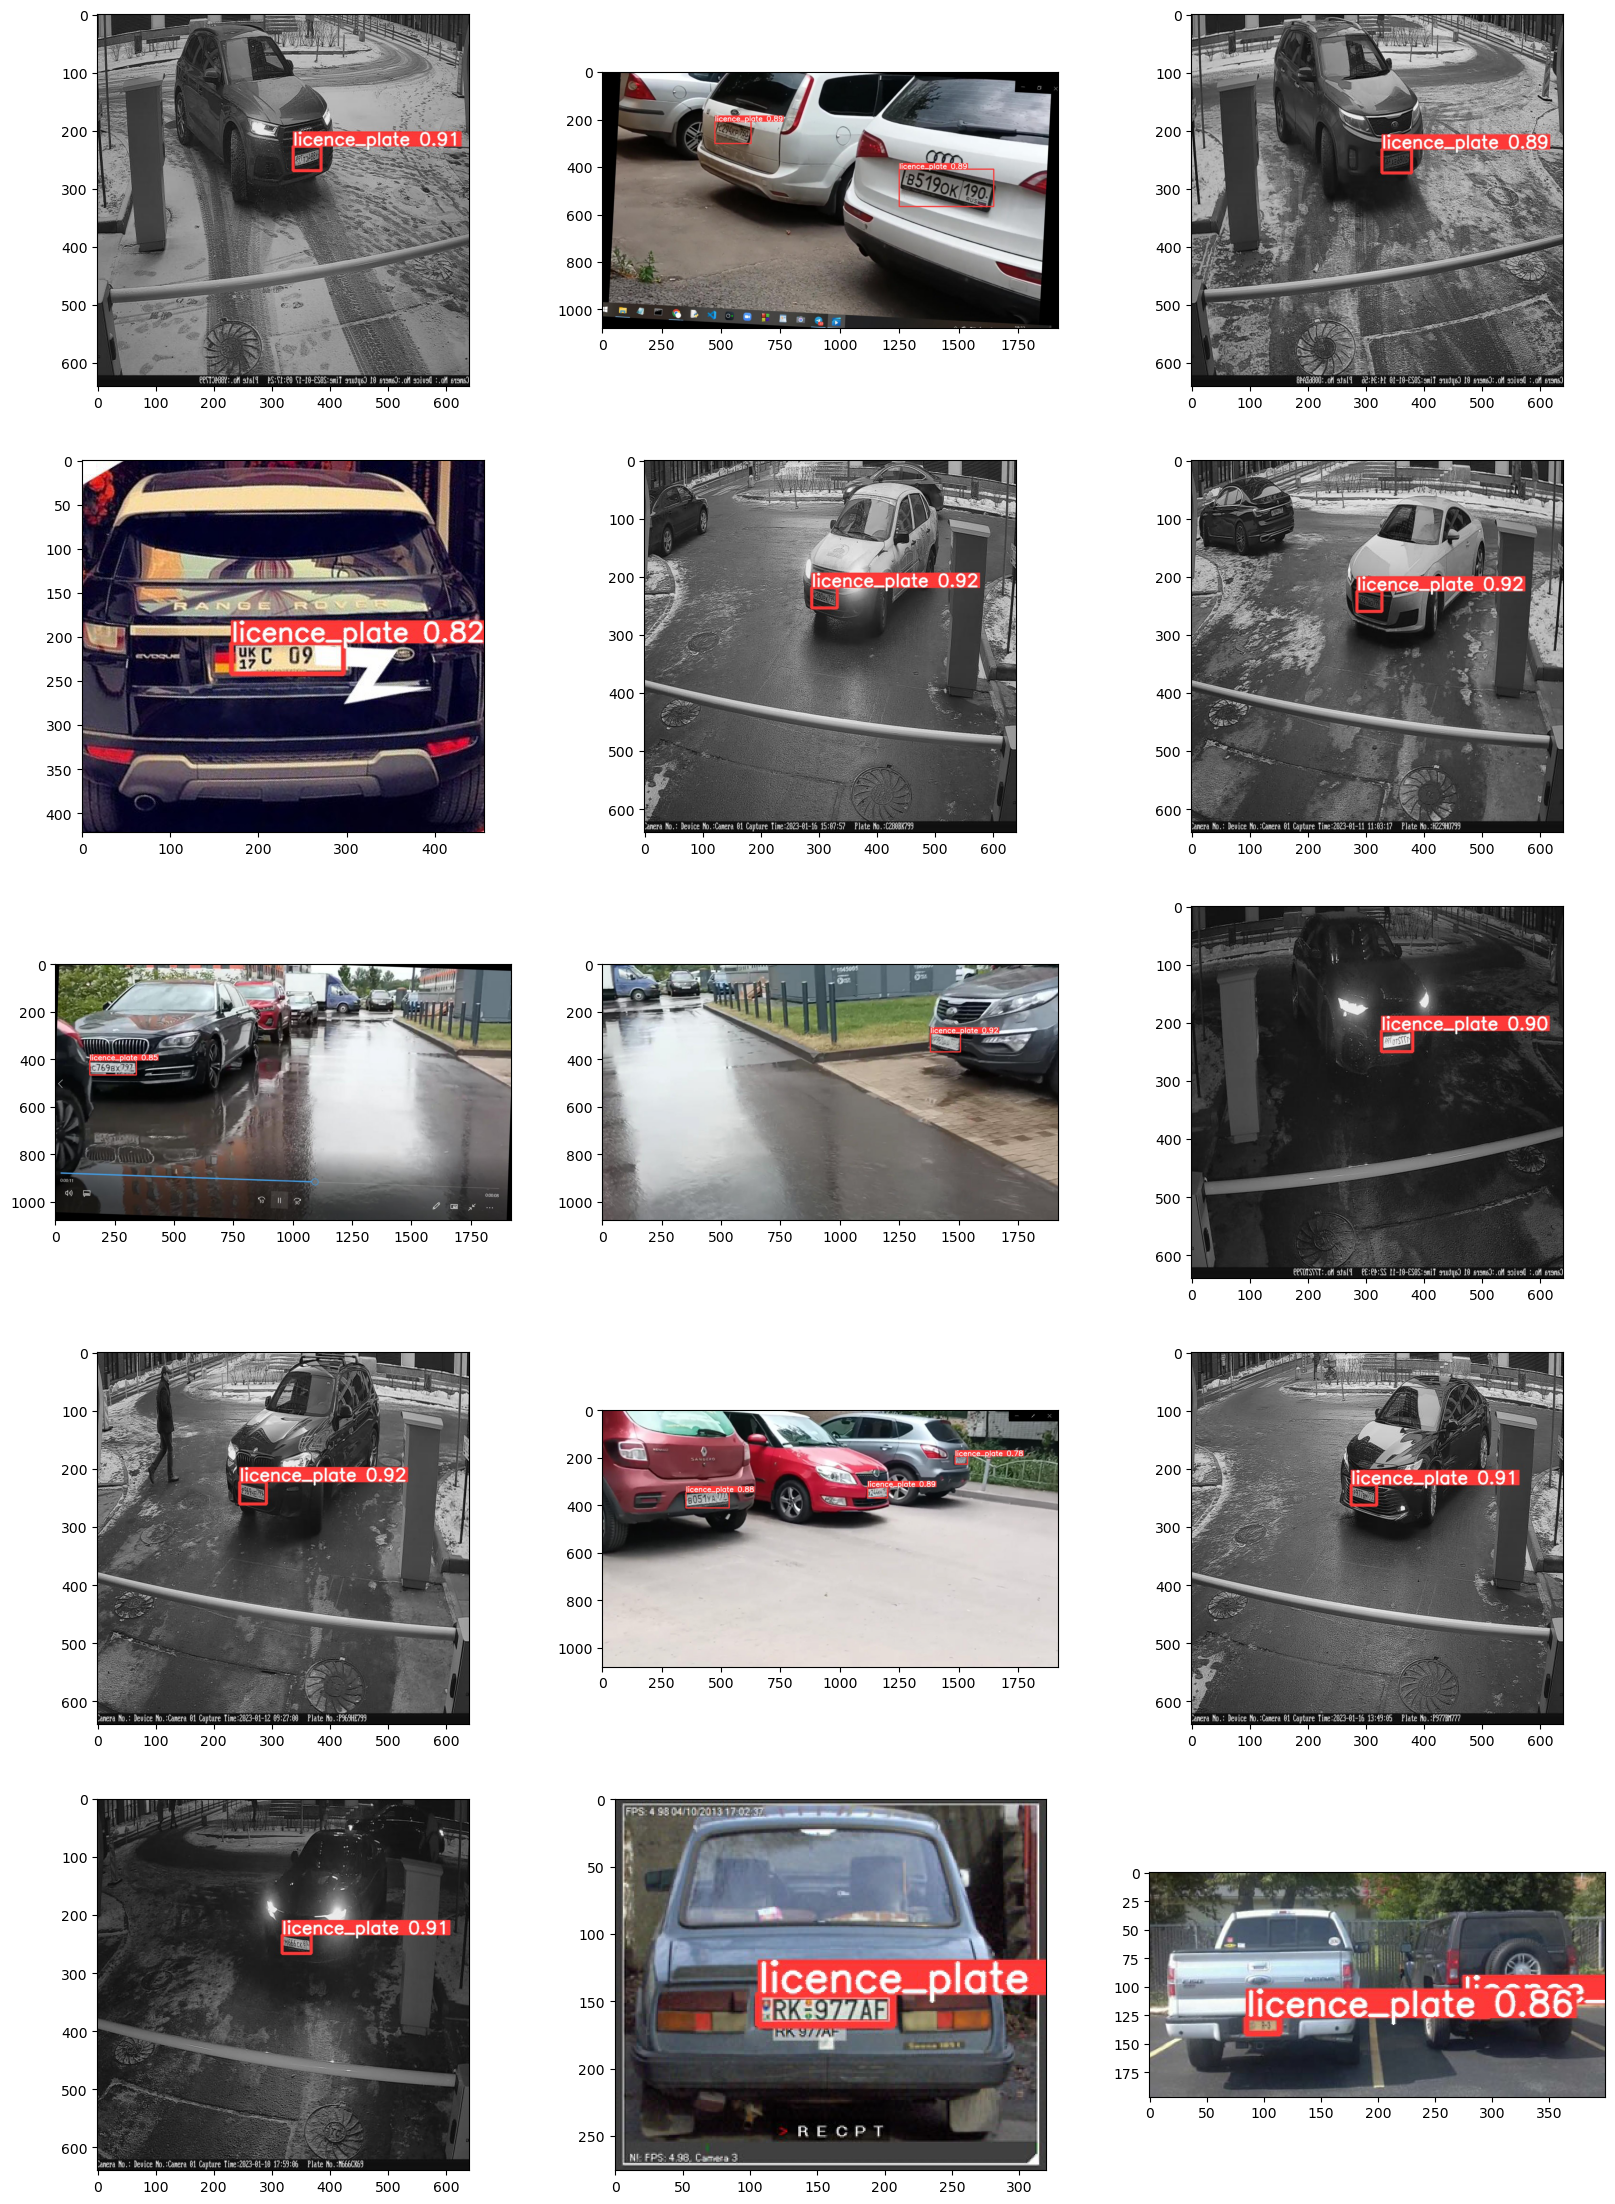

In [13]:
disp_images = glob(r'.\yolov5\runs\detect\exp2\*')
fig = plt.figure(figsize=(20, 28))
columns = 3
rows = 5
for i in range(1, columns * rows + 1):
    img = np.random.choice(disp_images)
    img = plt.imread(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

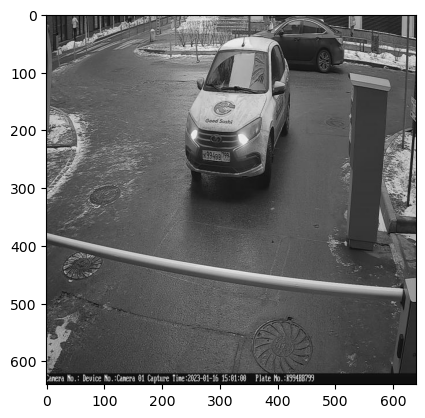

In [8]:
imges_path = glob('./data/splitted/val/images/*')
rand_indx = random.randint(0, len(imges_path))
plt.imshow(plt.imread(imges_path[rand_indx]))

Посмотреть че оно кропит

In [8]:
imges_path = glob('./data/splitted/val/images/*_*_jpg.rf*')
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5/runs/train/exp2/weights/best.pt')
columns = 3
rows = 3
cv2.namedWindow("preview")
for i in range(1, columns * rows + 1):
    img = cv2.imread(random.choice(imges_path))
    results = list(map(lambda x: int(round(x, 0)), model(img).xyxy[0][0].detach().cpu().numpy()))
    img = img[results[1]:results[3], results[0]:results[2]]
    cv2.imshow("preview", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Using cache found in C:\Users\nicka/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-5 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Сохранять чё оно кропит

In [2]:
os.makedirs('./data/cropped', exist_ok=True)
imges_path = glob('./data/splitted/val/images/*_*_jpg.rf*')
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5/runs/train/exp2/weights/best.pt')
for img_path in imges_path:
    img = cv2.imread(img_path)
    results = list(map(lambda x: int(round(x, 0)), model(img).xyxy[0][0].detach().cpu().numpy()))
    img = img[results[1]:results[3], results[0]:results[2]]
    cv2.imwrite('./data/cropped/' + os.path.basename(img_path), img)

Using cache found in C:\Users\nicka/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-5 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [2]:
import unittest
class Testing(unittest.TestCase):
    def setUp(self):
        self.a = '10'
    def test1(self):
        print(self.a)
    def test2(self):
        print(self.a+'dsadsa')
if __name__ == '__main__':
    unittest.main()

E
ERROR: C:\Users\nicka\AppData\Roaming\jupyter\runtime\kernel-b0b056db-ffe1-4212-b2d4-576a3793ecda (unittest.loader._FailedTest.C:\Users\nicka\AppData\Roaming\jupyter\runtime\kernel-b0b056db-ffe1-4212-b2d4-576a3793ecda)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute 'C:\Users\nicka\AppData\Roaming\jupyter\runtime\kernel-b0b056db-ffe1-4212-b2d4-576a3793ecda'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: 1

D:\hran\MachineLearning\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Распознование текста

# Без сплита по каждой буковке

## Pytesseract 

Грустно работает

In [1]:
!pip install pytesseract

  Obtaining dependency information for pytesseract from https://files.pythonhosted.org/packages/c5/54/ec007336f38d2d4ce61f3544af3e6855dacbf04a1ac8294f10cabe81146f/pytesseract-0.3.10-py3-none-any.whl.metadata


In [28]:
from PIL import Image
import pytesseract

# If you don't have tesseract executable in your PATH, include the following:
pytesseract.pytesseract.tesseract_cmd = r'D:\Github proj\MachineLearning\ML\Neuro-webs_competition\tesseract\tesseract.exe'
# Example tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

# Simple image to string
image = cv2.imread('./data/cropped/20230103204038_T253OX199_jpg.rf.bc801add5bdf911833f6435644cdd5fe.jpg')


# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# noise removal
def remove_noise(image):
    return cv2.medianBlur(image, 5)


#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


#dilation
def dilate(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)


#erosion
def erode(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.erode(image, kernel, iterations=1)


#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)


#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)


#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
        return rotated


#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)


gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)

tessdata_dir_config = '--tessdata-dir "D:\\Github proj\\MachineLearning\\ML\\Neuro-webs_competition\\tesseract\\tessdata"'

pytesseract.image_to_string(canny, config=tessdata_dir_config)

'weary\n'

## Easy OCR

Грустно работает

In [1]:
!pip install easyocr

  Using cached easyocr-1.7.1-py3-none-any.whl.metadata (11 kB)
Using cached easyocr-1.7.1-py3-none-any.whl (2.9 MB)


In [7]:
import easyocr

reader = easyocr.Reader(['en'], gpu=True)
result = reader.readtext('./data/cropped/20230102070343_A999KE99_jpg.rf.6262aeacad392db7741ec4c24555008c.jpg')
print(result)

[([[1.282041841382262, 2.133308787593881], [52.92865229583423, 9.47056603643766], [49.71795815861774, 31.86669121240612], [-1.9286522958342365, 24.52943396356234]], 'Lukea', 0.037236260151718985)]


## Собственная неронка

### Train test

In [117]:
for dir1 in ['train', 'test']:
    os.mkdir('./data/cropped/' + dir1)

In [118]:
dest_path = './data/cropped/'
files = glob(dest_path + '*.jpg')


def noplate_filter(x):
    x = os.path.basename(x)[
        os.path.basename(x).find('_') + 1: os.path.basename(x).find('_', os.path.basename(x).find('_') + 1)]
    if x != 'noPlate':
        return True
    else:
        return False


files = list(filter(noplate_filter, files))
random.shuffle(files)
training = files[:int(len(files) * 0.8)]
testing = files[int(len(files) * 0.8):int(len(files) * 1) + 1]
for train in training:
    shutil.copy(train, dest_path + 'train')
for test in testing:
    shutil.copy(test, dest_path + 'test')

In [115]:
files

['./data/cropped\\20230117073635_C056CA197_jpg.rf.b4c651ef2e4da548a279ee90c95c0f81.jpg',
 './data/cropped\\20230110162255_O875CK197_jpg.rf.8c991bea5d485b6d1ae90d940f8db640.jpg',
 './data/cropped\\20230116083321_E108KM797_jpg.rf.35233d541895faf25f12bd2dcc289b15.jpg',
 './data/cropped\\20230113185525_H888PT32_jpg.rf.b13d182dd084fd38c21b7164300596ea.jpg',
 './data/cropped\\20230116074858_H841MX797_jpg.rf.ce77cd41bca3e99e2bd44a4dbb233894.jpg',
 './data/cropped\\20230114194426_Y425HH799_jpg.rf.28cec41e3d90d32b3e38b3df6d71e60a.jpg',
 './data/cropped\\20230103172345_P136OM79_jpg.rf.597f58ed7af6c3f24ef1726bd34c695e.jpg',
 './data/cropped\\20230102070343_A999KE99_jpg.rf.6262aeacad392db7741ec4c24555008c.jpg',
 './data/cropped\\20230112155903_O230PA799_jpg.rf.88af38b0d33dbaefe5a6f070c3c7a863.jpg',
 './data/cropped\\20230111194545_B097HX790_jpg.rf.5bdb583c45aaf6d13eb52f87d21c98c5.jpg',
 './data/cropped\\20230108211824_E163AE977_jpg.rf.867eae89c859a2a9be37b9827ec6ef43.jpg',
 './data/cropped\\202301

### Анализ авто знаков

In [3]:
licenses = list(map(lambda x: os.path.basename(x)[os.path.basename(x).find('_') + 1:os.path.basename(x).find('_',
                                                                                                             os.path.basename(
                                                                                                                 x).find(
                                                                                                                 '_') + 1)],
                    glob('./data/cropped/*.jpg')))
licenses = [license for license in licenses if license != 'noPlate']
licenses_dict = Counter(''.join(licenses))
all_sumbols = dict(sorted(licenses_dict.items()))
all_sumbols

{'0': 126,
 '1': 93,
 '2': 83,
 '3': 109,
 '4': 81,
 '5': 64,
 '6': 107,
 '7': 431,
 '8': 86,
 '9': 356,
 'A': 56,
 'B': 85,
 'C': 89,
 'E': 53,
 'H': 79,
 'K': 108,
 'M': 59,
 'O': 47,
 'P': 30,
 'T': 76,
 'X': 59,
 'Y': 45}

Мы получили все вхождения цифр и букв в наших лицензиях как и сколько всего этих вхождений было

In [4]:
ALL_CHAR_SET = list(all_sumbols.keys()) + ['_']  # Добавляем пропуск т.к. у нас бывают разные авто номера
ALL_CHAR_SET_LEN = len(ALL_CHAR_SET)
print(ALL_CHAR_SET, ALL_CHAR_SET_LEN, sep='\n')

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'E', 'H', 'K', 'M', 'O', 'P', 'T', 'X', 'Y', '_']
23


И максимальное количество символов в лицензии

In [5]:
MAX_LEN_LICENSE = max(list(map(len, licenses)))
MAX_LEN_LICENSE

9

### Dataloader

In [7]:
def dataloader(paths, batch_size=32, device='cuda'):
    iteration = 0
    transform = transforms.Compose([
        transforms.Resize([64, 128]),
        transforms.ToTensor(),
    ])
    for i in range(0, len(paths), batch_size):
        imgs = []
        labels = []
        for img_path in paths[i:i + batch_size]:
            img_name = os.path.basename(img_path)
            label = img_name[img_name.find('_') + 1:img_name.find('_', img_name.find('_') + 1)]
            img = Image.open(img_path).convert('L')
            imgs.append(transform(img).to(device))
            labels.append(label)
        iteration += 1
        yield imgs, labels

In [15]:
train_dataloader = dataloader(glob('./data/cropped/train/*.jpg'), batch_size=16, device=device)
next(train_dataloader)

([tensor([[[0.2314, 0.2353, 0.2471,  ..., 0.4000, 0.3686, 0.3608],
           [0.2000, 0.2039, 0.2118,  ..., 0.3412, 0.3137, 0.3098],
           [0.1451, 0.1451, 0.1490,  ..., 0.2314, 0.2196, 0.2157],
           ...,
           [0.1137, 0.1137, 0.1176,  ..., 0.1490, 0.1490, 0.1490],
           [0.1098, 0.1098, 0.1137,  ..., 0.1451, 0.1490, 0.1490],
           [0.1098, 0.1098, 0.1137,  ..., 0.1451, 0.1490, 0.1490]]],
         device='cuda:0'),
  tensor([[[0.4235, 0.4235, 0.4314,  ..., 0.2275, 0.2196, 0.2157],
           [0.3725, 0.3765, 0.3843,  ..., 0.2000, 0.2039, 0.2039],
           [0.3059, 0.3098, 0.3216,  ..., 0.1804, 0.1961, 0.2000],
           ...,
           [0.2078, 0.2078, 0.2039,  ..., 0.2431, 0.2196, 0.2157],
           [0.2196, 0.2196, 0.2196,  ..., 0.2078, 0.1882, 0.1843],
           [0.2275, 0.2275, 0.2353,  ..., 0.1843, 0.1686, 0.1647]]],
         device='cuda:0'),
  tensor([[[0.2627, 0.2588, 0.2510,  ..., 0.2588, 0.2627, 0.2627],
           [0.2627, 0.2627, 0.2549,  ..

torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])
torch.Size([1, 64, 128])


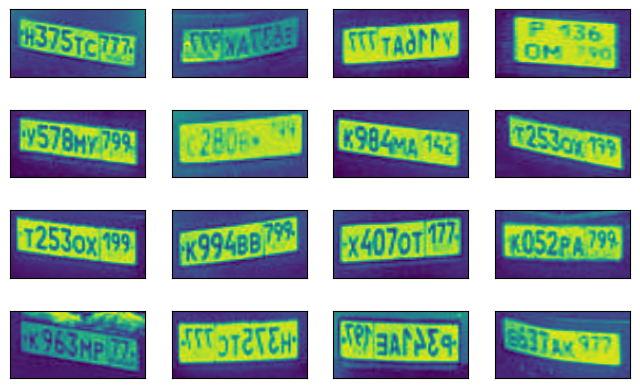

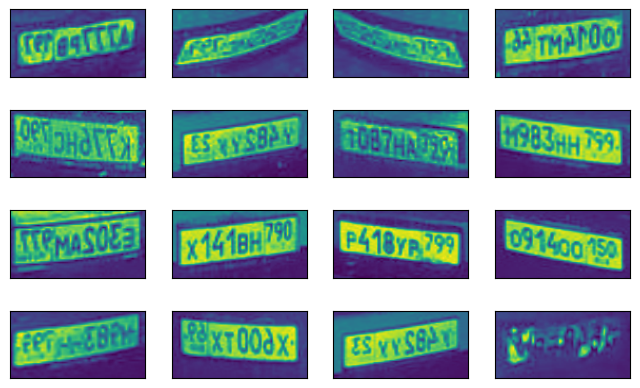

In [16]:
batch = 0
for e, (real, _) in enumerate(train_dataloader):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 5),  #Размер вывода
                             subplot_kw={'xticks': [], 'yticks': []})
    img_indx = 0
    for i, ax in enumerate(axes):
        for count in range(4):
            print(np.shape(real[img_indx]))
            ax[count].imshow(real[img_indx].cpu().detach().numpy().transpose((1, 2, 0)))
            img_indx += 1
    batch += 1
    if batch == 2:
        break

In [10]:
x = torch.rand(1, 1, 64, 128)
layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, stride=(1, 2), kernel_size=5, padding=2, bias=False),
                       nn.LeakyReLU(0.2, inplace=True),

                       nn.Conv2d(in_channels=32, out_channels=128, stride=1, kernel_size=5, padding=2, bias=False),
                       nn.BatchNorm2d(num_features=128),
                       nn.LeakyReLU(0.2, inplace=True), )
layer2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, stride=1, kernel_size=5, padding=2, bias=False),
                       nn.BatchNorm2d(num_features=256),
                       nn.LeakyReLU(0.2, inplace=True), )

layer3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, stride=1, kernel_size=5, padding=2, bias=False),
                       nn.BatchNorm2d(num_features=512),
                       nn.LeakyReLU(0.2, inplace=True),

                       nn.Conv2d(in_channels=512, out_channels=1, stride=4, kernel_size=5, padding=1, bias=False),
                       nn.LeakyReLU(0.2, inplace=True),
                       )
output = nn.Sequential(nn.Linear(in_features=256, out_features=ALL_CHAR_SET_LEN * MAX_LEN_LICENSE, bias=True),
                       nn.Sigmoid())
x = layer3(layer2(layer1(x)))
print(x.size())
print(output(x.view(x.size(0), -1)).size())

torch.Size([1, 1, 16, 16])
torch.Size([1, 207])


In [6]:
def encode(a):
    onehot = [0] * ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot


encode('_')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [7]:
class Mydataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.img = os.listdir(self.path)
        # if is_train:
        #     self.img = os.listdir(self.path)[:250]
        # else:
        #     self.img = os.listdir(self.path)[251:]
        self.transform = transform

    def __getitem__(self, idx):
        img_name = self.img[idx]
        img = Image.open(os.path.join(self.path, img_name))
        img = img.convert('L')
        label = img_name[img_name.find('_') + 1:img_name.find('_', img_name.find('_') + 1)]
        while len(label) < 9:
            label += '_'
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label

    def __len__(self):
        return len(self.img)


transform = transforms.Compose([
    transforms.Resize([64, 128]),
    transforms.ToTensor(),
])

train_ds = Mydataset('./data/cropped/train', transform=transform)
test_ds = Mydataset('./data/cropped/test', transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)
val_dl = DataLoader(test_ds, batch_size=64, num_workers=0)

In [21]:
class Img_to_text(nn.Module):
    def __init__(self):
        super(Img_to_text, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, stride=(1, 2), kernel_size=5, padding=2, bias=False),
                               nn.LeakyReLU(0.2, inplace=True),

                               nn.Conv2d(in_channels=32, out_channels=128, stride=1, kernel_size=5, padding=2, bias=False),
                               nn.BatchNorm2d(num_features=128),
                               nn.LeakyReLU(0.2, inplace=True), )
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, stride=1, kernel_size=5, padding=2, bias=False),
                               nn.BatchNorm2d(num_features=256),
                               nn.LeakyReLU(0.2, inplace=True), )
        
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, stride=1, kernel_size=5, padding=2, bias=False),
                               nn.BatchNorm2d(num_features=512),
                               nn.LeakyReLU(0.2, inplace=True),
        
                               nn.Conv2d(in_channels=512, out_channels=1, stride=4, kernel_size=5, padding=1, bias=False),
                               nn.LeakyReLU(0.2, inplace=True),
                               )
        self.output = nn.Linear(in_features=256, out_features=ALL_CHAR_SET_LEN * MAX_LEN_LICENSE, bias=True)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.output(x)
        return x

    def inference(self, x):
        pred = self.forward(x)
        c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
        c1 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN * 2])]
        c2 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 2:ALL_CHAR_SET_LEN * 3])]
        c3 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 3:ALL_CHAR_SET_LEN * 4])]
        c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 4:ALL_CHAR_SET_LEN * 5])]
        c5 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 5:ALL_CHAR_SET_LEN * 6])]
        c6 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 6:ALL_CHAR_SET_LEN * 7])]
        c7 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 7:ALL_CHAR_SET_LEN * 8])]
        c8 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 8:ALL_CHAR_SET_LEN * 9])]
        c = '%s%s%s%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5, c6, c7, c8)
        return c

In [22]:
model = Img_to_text()
model.cuda()
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.003)

In [23]:
for epoch in range(20):
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = img.cuda()
        label_oh = label_oh.float().cuda()
        pred = model(img)
        loss = loss_func(pred, label_oh)
        # print(pred)
        # print(label)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', loss.item())
        if epoch % 3 == 0 and step == 2:
            img, label_oh, label = next(iter(val_dl))
            img = img.cuda()
            label_oh = label_oh.float().cuda()
            pred = model(img)
            loss = loss_func(pred, label_oh)
            print('test loss: ', loss.item())

epoch: 1 step: 1 loss: 0.7007772922515869
epoch: 1 step: 2 loss: 1.050767421722412
epoch: 1 step: 3 loss: 0.9095973968505859
test loss:  0.9263104200363159
epoch: 1 step: 4 loss: 0.7544037699699402
epoch: 2 step: 1 loss: 0.3492434024810791
epoch: 2 step: 2 loss: 0.2979464530944824
epoch: 2 step: 3 loss: 0.30053138732910156
epoch: 2 step: 4 loss: 0.26235431432724
epoch: 3 step: 1 loss: 0.29299628734588623
epoch: 3 step: 2 loss: 0.25986772775650024
epoch: 3 step: 3 loss: 0.21352741122245789
epoch: 3 step: 4 loss: 0.18143463134765625
epoch: 4 step: 1 loss: 0.18775978684425354
epoch: 4 step: 2 loss: 0.18240775167942047
epoch: 4 step: 3 loss: 0.16948086023330688
test loss:  0.151376873254776
epoch: 4 step: 4 loss: 0.13383004069328308
epoch: 5 step: 1 loss: 0.1625257134437561
epoch: 5 step: 2 loss: 0.1541277915239334
epoch: 5 step: 3 loss: 0.15223079919815063
epoch: 5 step: 4 loss: 0.13163945078849792
epoch: 6 step: 1 loss: 0.157796248793602
epoch: 6 step: 2 loss: 0.13938428461551666
epoch: 

In [24]:
model.eval()

Img_to_text(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(512, 1, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1)

In [25]:
for step, (img, label_oh, label) in enumerate(test_dl):
    img = img.cuda()
    print(label,': ',model.inference(img))

('M093BB799',) :  B603TK797
('C280BK799',) :  A379MB797
('K994BB799',) :  C284TA799
('X580YK163',) :  T203TK797
('E640KK164',) :  K283TK799
('H375TC777',) :  M180BK799
('A157CB57_',) :  K304TC797
('Y116AT777',) :  H793TC799
('P136OM79_',) :  H964TA199
('C280BK799',) :  H400TC777
('T253OX199',) :  X283TK799
('C779EM62_',) :  T309KK797
('E637AK977',) :  M183TX799
('A777PB197',) :  K689HO797
('T087HA790',) :  Y303TO797
('M983HH799',) :  K283TC799
('E302AM977',) :  K359TO797
('P418YP799',) :  M383TK797
('O480MX797',) :  H364TC797
('E163AE977',) :  A369TB797
('K776HC790',) :  H001TC777
('X885YB799',) :  Y369TC797
('E163AE977',) :  M303TC799
('X926TO777',) :  C640TE797
('Y329PO799',) :  H669TC797
('Y329PO799',) :  H369TC797
('K495EH763',) :  K309TC797
('M072XB799',) :  H304TC797
('B838MX799',) :  Y303TC797
('P969HE799',) :  K669MO797
('Y833MH799',) :  C309TO797
('E637AK977',) :  K302TO797
('P108KM797',) :  T303TO797
('M566EB13_',) :  O382BC799
('C280BK799',) :  H304TK797
('T707HE799',) :  H6

# ResNet18

In [26]:
def encode(a):
    onehot = [0] * ALL_CHAR_SET_LEN
    idx = ALL_CHAR_SET.index(a)
    onehot[idx] += 1
    return onehot


encode('_')

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [27]:
def dataloader(paths, batch_size=32, device='cuda'):
    iteration = 0
    transform = transforms.Compose([
        transforms.Resize([64, 128]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    for i in range(0, len(paths), batch_size):
        imgs = []
        labels_oh = []
        labels = []
        for img_path in paths[i:i + batch_size]:

            img_name = os.path.basename(img_path)
            label = img_name[img_name.find('_') + 1:img_name.find('_', img_name.find('_') + 1)]
            labels.append(label)

            img = Image.open(img_path).convert('L')
            imgs.append(transform(img).to(device))

            while len(label) < 9:
                label += '_'
            label_oh = []
            for char in label:
                label_oh += encode(char)

            labels_oh.append(label_oh)
        iteration += 1
        yield imgs, np.array(labels_oh), labels


train_dataloader = dataloader(glob('./data/cropped/train/*.jpg'), batch_size=16, device=device)

In [28]:
os.path.basename(glob('./data/cropped/train/*.jpg')[0])

'20230101121559_H309TC777_jpg.rf.1e02ccf23c7ef7754014c9c1ab4b5ae8.jpg'

In [40]:
class Mydataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.img = os.listdir(self.path)
        # if is_train:
        #     self.img = os.listdir(self.path)[:250]
        # else:
        #     self.img = os.listdir(self.path)[251:]
        self.transform = transform

    def __getitem__(self, idx):
        img_name = self.img[idx]
        img = Image.open(os.path.join(self.path, img_name))
        img = img.convert('L')
        label = img_name[img_name.find('_') + 1:img_name.find('_', img_name.find('_') + 1)]
        while len(label) < 9:
            label += '_'
        label_oh = []
        for i in label:
            label_oh += encode(i)
        if self.transform is not None:
            img = self.transform(img)
        return img, np.array(label_oh), label

    def __len__(self):
        return len(self.img)


transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])

train_ds = Mydataset('./data/cropped/train', transform=transform)
test_ds = Mydataset('./data/cropped/test', transform)
train_dl = DataLoader(train_ds, batch_size=64, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=1, num_workers=0)
val_dl = DataLoader(test_ds, batch_size=64, num_workers=0)

In [143]:
for step, i in enumerate(train_dl):
    img, label_oh, label = i
    print(label_oh)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1]], dtype=torch.int32)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
tensor([[0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)


### Resnet + RNN

In [34]:
resnet = models.resnet18(weights=None)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(512, 256, bias=True)


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.lstm1 = nn.LSTM(256, hidden_size=128, bias=True, bidirectional=True, batch_first=True)  #)
        self.lstm2 = nn.LSTM(256, hidden_size=64, bias=True, dropout=0.25, bidirectional=True,batch_first=True)
        self.fc = nn.Linear(128, out_features=ALL_CHAR_SET_LEN * MAX_LEN_LICENSE, bias=True)

    def forward(self, x):
        x, states1 = self.lstm1(x)
        x, states2 = self.lstm2(x)
        x = self.fc(x)
        return x


model = nn.Sequential(resnet,
                      RNN())

model.cuda()
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), weight_decay=0.01)

In [45]:
resnet = models.resnet18(weights=None)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#resnet.fc = nn.Linear(512, 256, bias=True)


class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.lstm1 = nn.RNN(1000, hidden_size=512,num_layers=3,batch_first=True)  #)
        self.lstm2 = nn.RNN(512, hidden_size=256, num_layers=3,batch_first=True)
        self.fc = nn.Linear(256, out_features=ALL_CHAR_SET_LEN * MAX_LEN_LICENSE, bias=True)

    def forward(self, x):
        x, states1 = self.lstm1(x)
        x, states2 = self.lstm2(x)
        x = self.fc(x)
        return x

rnn = RNN()
model = nn.Sequential(resnet,
                      rnn)

model.cuda()
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), weight_decay=0.01)

### Only Resnet ++

In [30]:
model = models.resnet18(weights=None)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, ALL_CHAR_SET_LEN * MAX_LEN_LICENSE, bias=True)

model.cuda()
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
model = models.resnet18(weights=None)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 256, bias=True)

model = nn.Sequential(model,
                      nn.LeakyReLU(0.2),
                      nn.Linear(256, ALL_CHAR_SET_LEN * MAX_LEN_LICENSE, bias=True))

model.cuda()
loss_func = nn.MultiLabelSoftMarginLoss()
optm = torch.optim.Adam(model.parameters(), lr=0.003)

In [37]:
#model.eval()

In [42]:
for epoch in range(20):
    for step, i in enumerate(train_dl):
        img, label_oh, label = i
        img = img.cuda()
        label_oh = label_oh.float().cuda()
        pred = model(img)
        loss = loss_func(pred, label_oh)
        # print(pred)
        # print(label)
        optm.zero_grad()
        loss.backward()
        optm.step()
        print('epoch:', epoch + 1, 'step:', step + 1, 'loss:', loss.item())
        if epoch % 3 == 0 and step == 2:
            img, label_oh, label = next(iter(val_dl))
            img = img.cuda()
            label_oh = label_oh.float().cuda()
            pred = model(img)
            loss = loss_func(pred, label_oh)
            print('test loss: ', loss.item())

epoch: 1 step: 1 loss: 0.7005746960639954
epoch: 1 step: 2 loss: 0.5500198602676392
epoch: 1 step: 3 loss: 0.2799127697944641
test loss:  0.18151254951953888
epoch: 1 step: 4 loss: 0.17975939810276031
epoch: 2 step: 1 loss: 0.1941060721874237
epoch: 2 step: 2 loss: 0.16778354346752167
epoch: 2 step: 3 loss: 0.14268803596496582
epoch: 2 step: 4 loss: 0.13328003883361816
epoch: 3 step: 1 loss: 0.15816104412078857
epoch: 3 step: 2 loss: 0.14525820314884186
epoch: 3 step: 3 loss: 0.1394525021314621
epoch: 3 step: 4 loss: 0.12512613832950592
epoch: 4 step: 1 loss: 0.1419423669576645
epoch: 4 step: 2 loss: 0.13258366286754608
epoch: 4 step: 3 loss: 0.1300671398639679
test loss:  0.13086827099323273
epoch: 4 step: 4 loss: 0.1213398277759552
epoch: 5 step: 1 loss: 0.1365700364112854
epoch: 5 step: 2 loss: 0.12828709185123444
epoch: 5 step: 3 loss: 0.1241319552063942
epoch: 5 step: 4 loss: 0.11529464274644852
epoch: 6 step: 1 loss: 0.1339985728263855
epoch: 6 step: 2 loss: 0.12569189071655273
e

In [43]:
model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [46]:
next(iter(train_dl))

[tensor([[[[0.2314, 0.2314, 0.2353,  ..., 0.3686, 0.3608, 0.3608],
           [0.2314, 0.2314, 0.2353,  ..., 0.3686, 0.3608, 0.3608],
           [0.2314, 0.2314, 0.2353,  ..., 0.3686, 0.3608, 0.3608],
           ...,
           [0.1098, 0.1098, 0.1098,  ..., 0.1490, 0.1490, 0.1490],
           [0.1098, 0.1098, 0.1098,  ..., 0.1490, 0.1490, 0.1490],
           [0.1098, 0.1098, 0.1098,  ..., 0.1490, 0.1490, 0.1490]]],
 
 
         [[[0.4235, 0.4235, 0.4235,  ..., 0.2157, 0.2157, 0.2157],
           [0.4235, 0.4235, 0.4235,  ..., 0.2157, 0.2157, 0.2157],
           [0.4235, 0.4235, 0.4235,  ..., 0.2157, 0.2157, 0.2157],
           ...,
           [0.2275, 0.2275, 0.2275,  ..., 0.1686, 0.1647, 0.1647],
           [0.2275, 0.2275, 0.2275,  ..., 0.1686, 0.1647, 0.1647],
           [0.2275, 0.2275, 0.2275,  ..., 0.1686, 0.1647, 0.1647]]],
 
 
         [[[0.2627, 0.2627, 0.2588,  ..., 0.2627, 0.2627, 0.2627],
           [0.2627, 0.2627, 0.2588,  ..., 0.2627, 0.2627, 0.2627],
           [0.2627

In [58]:
for step, (img, label_oh, label) in enumerate(test_dl):
    img = img.cuda()
    pred = model(img)
    # for i in range(MAX_LEN_LICENSE):
    #     if i == 0:
    #         exec(f'c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]')
    #     else:
    #         print(ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*i:ALL_CHAR_SET_LEN*i+1])])
    #         exec(f'c{i} = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*{i}:ALL_CHAR_SET_LEN*{i}+1])]')
    # c = '%s'*9 % (c0,c1,c2,c3,c4,c5,c6,c7,c8)
    c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN * 2])]
    c2 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 2:ALL_CHAR_SET_LEN * 3])]
    c3 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 3:ALL_CHAR_SET_LEN * 4])]
    c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 4:ALL_CHAR_SET_LEN * 5])]
    c5 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 5:ALL_CHAR_SET_LEN * 6])]
    c6 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 6:ALL_CHAR_SET_LEN * 7])]
    c7 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 7:ALL_CHAR_SET_LEN * 8])]
    c8 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 8:ALL_CHAR_SET_LEN * 9])]
    c = '%s%s%s%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5, c6, c7, c8)

    print('label:', label[0], 'pred:', c)

label: M093BB799 pred: H309TC797
label: C280BK799 pred: H309TC797
label: K994BB799 pred: M381TC797
label: X580YK163 pred: Y683TC797
label: E640KK164 pred: H309TC797
label: H375TC777 pred: M381TC799
label: A157CB57_ pred: T362TO777
label: Y116AT777 pred: K381TC797
label: P136OM79_ pred: M381TC797
label: C280BK799 pred: M381TC777
label: T253OX199 pred: Y386TA797
label: C779EM62_ pred: H389TC799
label: E637AK977 pred: M389TC797
label: A777PB197 pred: H309TC797
label: T087HA790 pred: K362TB777
label: M983HH799 pred: Y309TC797
label: E302AM977 pred: K364TB777
label: P418YP799 pred: M389TC797
label: O480MX797 pred: H380TK779
label: E163AE977 pred: H309TC797
label: K776HC790 pred: M381TC797
label: X885YB799 pred: T362TO777
label: E163AE977 pred: Y309TC797
label: X926TO777 pred: K364TK797
label: Y329PO799 pred: K362TB777
label: Y329PO799 pred: K362TB777
label: K495EH763 pred: H280TK779
label: M072XB799 pred: K362TB777
label: B838MX799 pred: K362TB777
label: P969HE799 pred: H389TK797
label: Y83

In [49]:
ALL_CHAR_SET

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'E',
 'H',
 'K',
 'M',
 'O',
 'P',
 'T',
 'X',
 'Y',
 '_']

### Кароче решено что выборка маленькая не хватает мене

In [52]:
torch.save(model.state_dict(), './resnet18_auto-licenses_weights.pth')

In [33]:
loaded_model = models.resnet18(weights=None)
loaded_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
loaded_model.fc = nn.Linear(in_features=512, out_features=ALL_CHAR_SET_LEN * MAX_LEN_LICENSE, bias=True)
loaded_model.load_state_dict(torch.load('./resnet18_auto-licenses_weights.pth'))
loaded_model.cuda()
loaded_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
for step, (img, label_oh, label) in enumerate(test_dl):
    img = img.cuda()
    pred = loaded_model(img)
    # for i in range(MAX_LEN_LICENSE):
    #     if i == 0:
    #         exec(f'c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]')
    #     else:
    #         print(ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*i:ALL_CHAR_SET_LEN*i+1])])
    #         exec(f'c{i} = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN*{i}:ALL_CHAR_SET_LEN*{i}+1])]')
    # c = '%s'*9 % (c0,c1,c2,c3,c4,c5,c6,c7,c8)
    c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
    c1 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN * 2])]
    c2 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 2:ALL_CHAR_SET_LEN * 3])]
    c3 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 3:ALL_CHAR_SET_LEN * 4])]
    c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 4:ALL_CHAR_SET_LEN * 5])]
    c5 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 5:ALL_CHAR_SET_LEN * 6])]
    c6 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 6:ALL_CHAR_SET_LEN * 7])]
    c7 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 7:ALL_CHAR_SET_LEN * 8])]
    c8 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 8:ALL_CHAR_SET_LEN * 9])]
    c = '%s%s%s%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5, c6, c7, c8)

    print('label:', label[0], 'pred:', c)

NameError: name 'test_dl' is not defined

In [20]:
os.mkdir('./data/model_testing_imgs')

In [65]:
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
])
img = Image.open('./data/cropped/20230105182243_P418YP799_jpg.rf.02a518b45b99a4c5a62c40cbb7af7db6.jpg')
img = img.convert('L')
img = transform(img).to(device).unsqueeze(0)

pred = model(img)
c0 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[0:ALL_CHAR_SET_LEN])]
c1 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN:ALL_CHAR_SET_LEN * 2])]
c2 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 2:ALL_CHAR_SET_LEN * 3])]
c3 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 3:ALL_CHAR_SET_LEN * 4])]
c4 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 4:ALL_CHAR_SET_LEN * 5])]
c5 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 5:ALL_CHAR_SET_LEN * 6])]
c6 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 6:ALL_CHAR_SET_LEN * 7])]
c7 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 7:ALL_CHAR_SET_LEN * 8])]
c8 = ALL_CHAR_SET[np.argmax(pred.squeeze().cpu().tolist()[ALL_CHAR_SET_LEN * 8:ALL_CHAR_SET_LEN * 9])]
c = '%s%s%s%s%s%s%s%s%s' % (c0, c1, c2, c3, c4, c5, c6, c7, c8)
print(c)

A992KA797


### С разделением по буквам через cv2

Грустно работает

In [10]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

img = cv2.imread('./data/cropped/20230101121559_H309TC777_jpg.rf.1e02ccf23c7ef7754014c9c1ab4b5ae8.jpg')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh_inv = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 39, 1)
edges = auto_canny(thresh_inv)
ctrs, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
img_area = img.shape[0] * img.shape[1]
for i, ctr in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(ctr)
    roi_area = w * h
    roi_ratio = roi_area / img_area
    if ((roi_ratio >= 0.015) and (roi_ratio < 0.09)):
        if ((h > 1.2 * w) and (3 * w >= h)):
            cv2.rectangle(img, (x, y), (x + w, y + h), (90, 0, 255), 2)
            cv2.imshow('image',img)
            cv2.waitKey(0)

# ------------------------------------------------------------------

# Кроп всех картинок

In [66]:
from tqdm import tqdm
dest_path = './data/cropped/all/'
os.makedirs(dest_path, exist_ok=True)
imges_path = glob('./data/extracted/images/*.jpg')
model = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5/runs/train/exp2/weights/best.pt')
for img_path in tqdm(imges_path):
    img = cv2.imread(img_path)
    pred = model(img)
    if not pred.xyxy[0].nelement() == 0:
        results = list(map(lambda x: int(round(x, 0)), model(img).xyxy[0][0].detach().cpu().numpy()))
        img = img[results[1]:results[3], results[0]:results[2]]
        cv2.imwrite(dest_path + os.path.basename(img_path), img)

Using cache found in C:\Users\nicka/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-5 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
100%|██████████| 2421/2421 [00:50<00:00, 47.64it/s]


# Распознование

In [4]:
import easyocr

reader = easyocr.Reader(['en','ru'], gpu=True)
img = cv2.imread('./data/cropped/all/Cars32.jpg')
_, text, __ = reader.readtext(img)[0]
print(text)

MANISA


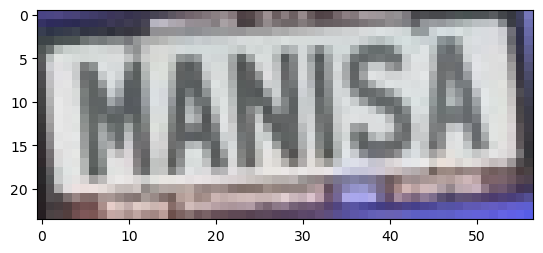

In [5]:
plt.imshow(img)

### Реально шото читает

# Получение фото

### Получение из видео

In [30]:
os.mkdir('./frames_capture')

In [1]:
import cv2
cam = cv2.VideoCapture(0)
cv2.namedWindow("test")
img_counter = 0
while True:
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)
    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "./frames_capture/opencv_frame_{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1
cam.release()
cv2.destroyAllWindows()

failed to grab frame


### Получение 1 фотка

In [2]:
def catch_photo(img_list, imges_count=1):
    import cv2
    cam = cv2.VideoCapture(0)
    frames = []
    fig, axes = plt.subplots(nrows=imges_count, ncols=1, figsize=(20, 15),  #Размер вывода
                             subplot_kw={'xticks': [], 'yticks': []})
    
    for i in range(imges_count):
        ret, frame = cam.read()
        if not ret:
            print("failed to grab frame")
            break
        axes[i].imshow(frame)
        frames.append(frame)
    return frames

img_list = []

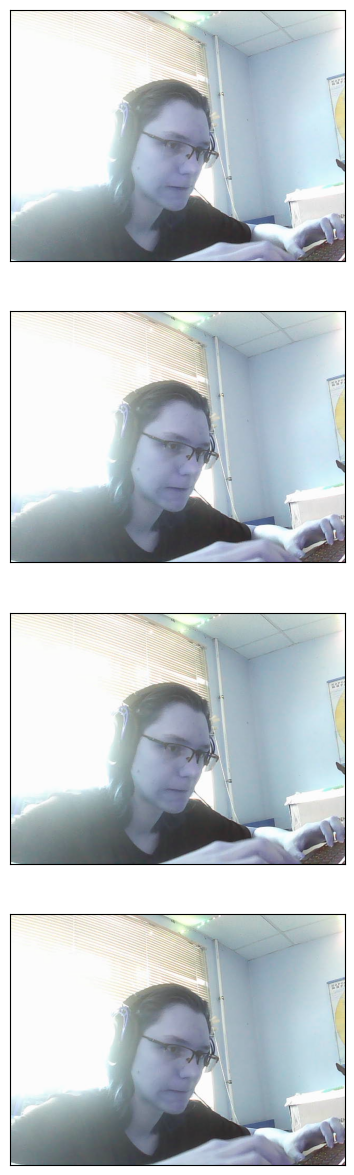

In [3]:
frames = catch_photo(img_list,4)

In [4]:
print(frames)

[array([[[244, 243, 239],
        [241, 240, 236],
        [236, 236, 230],
        ...,
        [246, 252, 234],
        [247, 255, 233],
        [247, 255, 231]],

       [[253, 253, 246],
        [251, 252, 244],
        [249, 250, 241],
        ...,
        [238, 244, 226],
        [239, 246, 225],
        [239, 247, 224]],

       [[255, 255, 244],
        [255, 255, 245],
        [255, 255, 246],
        ...,
        [243, 249, 232],
        [243, 250, 230],
        [243, 250, 230]],

       ...,

       [[252, 254, 255],
        [251, 254, 255],
        [247, 251, 255],
        ...,
        [122,  95, 102],
        [176, 147, 154],
        [167, 136, 144]],

       [[247, 246, 249],
        [247, 247, 250],
        [249, 251, 255],
        ...,
        [142, 110, 119],
        [160, 125, 135],
        [142, 107, 117]],

       [[255, 254, 255],
        [254, 252, 255],
        [248, 249, 252],
        ...,
        [138, 103, 113],
        [104,  68,  79],
        [123,  85,  97]

# Отправка результата распознования(в общем-то распознавание и вывод)

In [41]:
def predictions(frames):
    import torch
    import easyocr
    model = torch.hub.load('ultralytics/yolov5', 'custom', path='./yolov5/runs/train/exp2/weights/best.pt')
    predicts = []
    for img in frames:
        results = list(map(lambda x: int(round(x, 0)), model(img).xyxy[0][0].detach().cpu().numpy()))
        img = img[results[1]:results[3], results[0]:results[2]]
        
        reader = easyocr.Reader(['en','ru'], gpu=True)
        _, text, __ = reader.readtext(img)[0]
        predicts.append(text)
    return predicts
frames = [cv2.imread('./data/extracted/images/---------------670-_png.rf.026dd038b0ac1731af6989433614cf47.jpg'),cv2.imread('./data/extracted/images/Cars48.jpg')]

In [42]:
predictions(frames)

Using cache found in C:\Users\nicka/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-2-5 Python-3.11.5 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


['МО25т1 799', 'ALR 485']

# Апи будет находится в папке api

In [5]:
os.mkdir('./api')

In [5]:
from PIL import Image
import numpy as np
np.array(Image.open('./data/cropped/20230101121559_H309TC777_jpg.rf.1e02ccf23c7ef7754014c9c1ab4b5ae8.jpg'))

array([[[ 59,  59,  59],
        [ 67,  67,  67],
        [ 72,  72,  72],
        ...,
        [107, 107, 107],
        [112, 112, 112],
        [ 92,  92,  92]],

       [[ 32,  32,  32],
        [ 33,  33,  33],
        [ 34,  34,  34],
        ...,
        [ 59,  59,  59],
        [ 53,  53,  53],
        [ 47,  47,  47]],

       [[ 33,  33,  33],
        [ 34,  34,  34],
        [ 32,  32,  32],
        ...,
        [ 52,  52,  52],
        [ 50,  50,  50],
        [ 60,  60,  60]],

       ...,

       [[ 31,  31,  31],
        [ 30,  30,  30],
        [ 29,  29,  29],
        ...,
        [ 39,  39,  39],
        [ 38,  38,  38],
        [ 38,  38,  38]],

       [[ 29,  29,  29],
        [ 30,  30,  30],
        [ 30,  30,  30],
        ...,
        [ 38,  38,  38],
        [ 38,  38,  38],
        [ 38,  38,  38]],

       [[ 28,  28,  28],
        [ 29,  29,  29],
        [ 29,  29,  29],
        ...,
        [ 38,  38,  38],
        [ 37,  37,  37],
        [ 38,  38,  38]]

Не забывать комментарии к нейросети и апи, отсутствие ошибок и предупреждений

# GitHub Yolov5

In [65]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj\yolov5


Cloning into 'yolov5'...


D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj


In [14]:
for dir1 in ['train', 'val']:
    for dir2 in ['images', 'labels']:
        files = glob(f'./data/exported_data/splitted/{dir1}/{dir2}/*')
        for f in files:
            os.remove(f)

In [10]:
import yaml

data = {
    'train': r'..\data\exported_data\splitted\train',
    'val': r'..\data\exported_data\splitted\val',
    'nc': '5',
    'names': {0: 'D00', 1: 'D10', 2: 'D20', 3: 'D40', 4: 'Repair'}
}
with open('./yolov5/data/dataset.yaml', 'w', ) as f:
    yaml.dump(data, f, sort_keys=False)

In [2]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

set KMP_DUPLICATE_LIB_OK=True
set CUDA_LAUNCH_BLOCKING=1
set TORCH_USE_CUDA_DSA=1

![](./imgs/img_3.png)

In [1]:
%cd yolov5
!echo %cd%
!python train.py --img 720 --batch 16 --epochs 50 --data dataset.yaml --weights yolov5s.pt --nosave --cache --workers 0
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj\B\yolov5
D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj\B\yolov5
^C
D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj\B


# Yolo-Annotation-Tool

In [13]:
!git clone https://github.com/pascalberski/YOLO-Annotation-Tool

Cloning into 'YOLO-Annotation-Tool'...


### Запуск через Annotate.html

In [24]:
%cd YOLO-Annotation-Tool
!Annotate.html
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj\YOLO-Annotation-Tool
D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj


# Yolo-to-COCO-format-converter

In [6]:
!git clone https://github.com/Taeyoung96/Yolo-to-COCO-format-converter.git

fatal: destination path 'Yolo-to-COCO-format-converter' already exists and is not an empty directory.


Изменяем классы на свои в файле ./Yolo-to-COCO-format-converter/main.py

In [ ]:
С --yolo-subdir

![](./imgs/img.png)

In [ ]:
Без --yolo-subdir

![](./imgs/img_1.png)

In [9]:
%cd Yolo-to-COCO-format-converter
!python main.py --yolo-subdir --path ..\data\full\ --output all.json
%cd ../

D:\Github proj\MachineLearning\ML\Neuro-webs_competition\road_holes\proj\A\Yolo-to-COCO-format-converter
Start!

Processing 0 ...
Processing 1 ...
Processing 2 ...
Processing 3 ...
Processing 4 ...
Processing 5 ...
Processing 6 ...
Processing 7 ...
Processing 8 ...
Processing 9 ...
Processing 10 ...
Processing 11 ...
Processing 12 ...
Processing 13 ...
Processing 14 ...
Processing 15 ...
Processing 16 ...
Processing 17 ...
Processing 18 ...
Processing 19 ...
Processing 20 ...
Processing 21 ...
Processing 22 ...
Processing 23 ...
Processing 24 ...
Processing 25 ...
Processing 26 ...
Processing 27 ...
Processing 28 ...
Processing 29 ...
Processing 30 ...
Processing 31 ...
Processing 32 ...
Processing 33 ...
Processing 34 ...
Processing 35 ...
Processing 36 ...
Processing 37 ...
Processing 38 ...
Processing 39 ...
Processing 40 ...
Processing 41 ...
Processing 42 ...
Processing 43 ...
Processing 44 ...
Processing 45 ...
Processing 46 ...
Processing 47 ...
Processing 48 ...
Processing 49 .

json спавнится в ./Yolo-to-COCO-format-converter/output/all.json

# _________________________________________________________________

Посмотреть как можно подбирать гипер параметры к yolov5
Позагружать yolo resnet модели с pytorch шобы не обос
